In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks")

from functools import partial
import jax
import jax.numpy as jnp
from jax import lax, vmap
from jax.scipy.stats import multivariate_normal
import jax.random as jrandom
import blackjax
from jaxtyping import Array, Float, PyTree, PRNGKeyArray
from typing import Callable, Tuple

import numpy as np

jax.config.update("jax_enable_x64", True)
key = jrandom.PRNGKey(123)

# No-U-Turn Sampler with Blackjax

Now we will use the No-U-Turn Sampler (NUTS) to sample the banana distribution.
Here is what the log density of the distribution looks like:

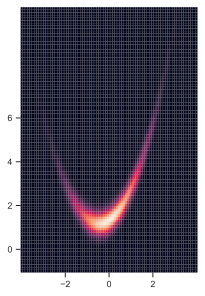

In [2]:
def banana_logdensity(x, a=1.15, b=0.5, rho=0.5):
    """A banana-shaped distribution. Comes from a nonlinear transformation of a correlated Gaussian."""
    x1, x2 = x
    u1 = x1/a
    u2 = a*(x2 - b*(u1**2 + a**2))
    return multivariate_normal.logpdf(jnp.array([u1, u2]), jnp.zeros(2), jnp.array([[1, rho], [rho, 1]]))

def plot_2d_function(f, alpha=1.0, plot_type="pcolormesh", ax=None, levels=None):
    x = jnp.linspace(-4, 4, 100)
    y = jnp.linspace(-1, 11, 100)
    X, Y = jnp.meshgrid(x, y)
    Z = vmap(f)(jnp.stack([X.flatten(), Y.flatten()], axis=1)).reshape(X.shape)

    if ax is None:
        _, ax = plt.subplots()
    if plot_type == "contour":
        ax.contour(X, Y, jnp.exp(Z), alpha=alpha, cmap="Greens", levels=levels)
    elif plot_type == "pcolormesh":
        ax.pcolormesh(X, Y, jnp.exp(Z), alpha=alpha)
    ax.set_xticks([-2, 0, 2])
    ax.set_yticks([0, 2, 4, 6])
    ax.set_aspect("equal")
    sns.despine(trim=True, left=True, bottom=True)
    return ax

banana_logdensity_high_curv = partial(banana_logdensity, a=1.15, b=1.0, rho=0.9)
plot_2d_function(banana_logdensity_high_curv);

## No-U-Turn Sampler (NUTS) recap

The NUTS algorithm is essentially Hamiltonian Monte Carlo (HMC) equipped with a heuristic which adaptively selects the number of steps each Hamiltonian trajectory takes.
We'll use the blackjax's implementation of NUTS.
Much of the code below is modified from [this blackjax tutorial](https://blackjax-devs.github.io/sampling-book/models/change_of_variable_hmc.html).

In [3]:
def run_inference(
    joint_log_prob: Callable, 
    sample_starting_point: Callable, 
    key: PRNGKeyArray, 
    num_warmup: int, 
    num_samples: int, 
    num_chains: int
):
    """Do warmup with window adaptation (to tune step size and mass matrix) and then sample using NUTS.
    Returns a tuple with the NUTS states and some info.
    """
    # Initialize the window adaptation algorithm
    warmup = blackjax.window_adaptation(blackjax.nuts, joint_log_prob)

    # Initialize the MCMC chain
    key, init_key, warmup_key, sample_key = jax.random.split(key, 4)
    init_position = sample_starting_point(init_key, num_chains)

    # Run the warmup phase for each chain
    @jax.vmap
    def call_warmup(seed, param):
        """Run the warmup phase for a single chain."""
        (initial_states, tuned_params), _ = warmup.run(seed, param, num_warmup)
        return initial_states, tuned_params
    warmup_keys = jax.random.split(warmup_key, num_chains)
    initial_states, tuned_params = jax.jit(call_warmup)(warmup_keys, init_position)

    # Run the sampling phase
    states, infos = inference_loop_multiple_chains(sample_key, initial_states, tuned_params, joint_log_prob, num_samples, num_chains)

    # `states` contains the samples, `infos` contains other information about the sampling process
    return states, infos

def sample_starting_point(
    key: PRNGKeyArray, 
    num_chains: int, 
    mu: Array, 
    Sigma: Array
):
    """Draw samples from a multivariate normal as starting points for the MCMC chains.
    Returns an array of shape (num_chains, num_dims).
    """
    keys = jrandom.split(key, num_chains)
    return vmap(lambda k: jrandom.multivariate_normal(k, mu, Sigma))(keys)

def inference_loop_multiple_chains(
    key: PRNGKeyArray, 
    initial_states: PyTree, 
    tuned_params: dict, 
    log_prob_fn: Callable, 
    num_samples: int, 
    num_chains: int
):
    """Do NUTS sampling for multiple chains in a vectorized fashion. Returns a tuple with the NUTS states and some info."""
    # Initialize the NUTS kernel
    kernel = blackjax.nuts.build_kernel()

    def step_fn(key, state, **params):
        """A single step of NUTS for one chain."""
        return kernel(key, state, log_prob_fn, **params)

    def one_step(states, key):
        """A single step of NUTS for multiple chains."""
        keys = jax.random.split(key, num_chains)
        states, infos = jax.vmap(step_fn)(keys, states, **tuned_params)
        return states, (states, infos)

    # Run the NUTS sampling for multiple chains
    keys = jax.random.split(key, num_samples)
    _, (states, infos) = jax.lax.scan(one_step, initial_states, keys)

    return (states, infos)

In [4]:
num_chains = 4
num_samples_per_chain = 500
num_warmup = 500

states, infos = run_inference(
    joint_log_prob=banana_logdensity_high_curv,
    sample_starting_point=partial(sample_starting_point, mu=jnp.zeros(2), Sigma=jnp.eye(2)),
    key=key,
    num_warmup=num_warmup,
    num_samples=num_samples_per_chain,
    num_chains=num_chains
)

Let's print some diagnostics and make the trace plot (with the help of the [`arviz`](https://python.arviz.org/en/stable/) library):

In [5]:
import arviz as az

def arviz_trace_from_states(states, info, burn_in=0):
    position = states.position
    if isinstance(position, jax.Array):  # if states.position is array of samples
        position = dict(samples=position)
    else:
        try:
            position = position._asdict()
        except AttributeError:
            pass

    samples = {}
    for param in position.keys():
        ndims = len(position[param].shape)
        if ndims >= 2:
            samples[param] = jnp.swapaxes(position[param], 0, 1)[
                :, burn_in:
            ]  # swap n_samples and n_chains
            divergence = jnp.swapaxes(info.is_divergent[burn_in:], 0, 1)

        if ndims == 1:
            divergence = info.is_divergent
            samples[param] = position[param]

    trace_posterior = az.convert_to_inference_data(samples)
    trace_sample_stats = az.convert_to_inference_data(
        {"diverging": divergence}, group="sample_stats"
    )
    trace = az.concat(trace_posterior, trace_sample_stats)
    return trace

trace = arviz_trace_from_states(states, infos)
summ_df = az.summary(trace)
summ_df

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
samples[0]  0.116  1.141  -1.777    2.338      0.107    0.076     114.0   
samples[1]  2.398  1.618   0.438    5.381      0.168    0.119     124.0   

            ess_tail  r_hat  
samples[0]     119.0   1.04  
samples[1]     134.0   1.03

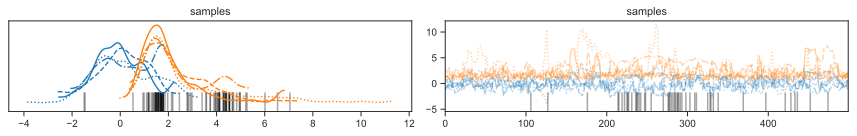

In [6]:
az.plot_trace(trace)
plt.tight_layout();

Let's look at $\hat{R}$ to assess convergence (see [the Metropolis-Hastings hands-on activity](https://predictivesciencelab.github.io/advanced-scientific-machine-learning/inverse/sampling/02_mcmc_blackjax.html) for more details):

In [7]:
samples = states.position.transpose(1, 0, 2)  # samples shape: (num_chains, num_samples, 2)
compute_diagnostics_every = 25
rhats = []
for i in range(2, num_samples_per_chain, compute_diagnostics_every):
    rhat = blackjax.diagnostics.potential_scale_reduction(samples[:, :i])
    rhats.append(rhat)
rhats = jnp.array(rhats)

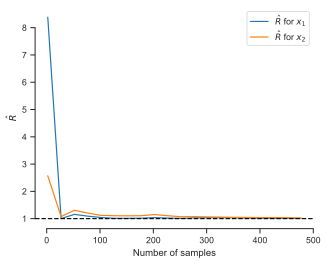

In [8]:
fig, ax = plt.subplots(figsize=(5,4))
ax.plot(range(2, num_samples_per_chain, compute_diagnostics_every), rhats[:,0], label=r"$\hat{R}$ for $x_1$")
ax.plot(range(2, num_samples_per_chain, compute_diagnostics_every), rhats[:,1], label=r"$\hat{R}$ for $x_2$")
ax.axhline(1.0, color="black", linestyle="--")
ax.set_xlabel("Number of samples")
ax.set_ylabel(r"$\hat{R}$")
ax.legend()
sns.despine(trim=True)

It looks like the chains converge fairly quickly.

Let's look at the effective sample size (ESS) to see how many independent samples we have (again, see [the Metropolis-Hastings hands-on activity](https://predictivesciencelab.github.io/advanced-scientific-machine-learning/inverse/sampling/02_mcmc_blackjax.html) for more details):

In [9]:
n_effs = []
for i in range(2, num_samples_per_chain, compute_diagnostics_every):
    n_eff = blackjax.diagnostics.effective_sample_size(samples[:, :i])
    n_effs.append(n_eff)
n_effs = jnp.array(n_effs)

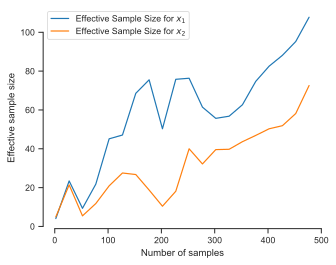

In [10]:
fig, ax = plt.subplots(figsize=(5,4))
ax.plot(range(2, num_samples_per_chain, compute_diagnostics_every), n_effs[:,0], label=r"Effective Sample Size for $x_1$")
ax.plot(range(2, num_samples_per_chain, compute_diagnostics_every), n_effs[:,1], label=r"Effective Sample Size for $x_2$")
ax.set_xlabel("Number of samples")
ax.set_ylabel("Effective sample size")
ax.legend()
sns.despine(trim=True)

The ESS is high. This is good&mdash;it means that our samples are not correlated, and we don't have to thin them out too much.

Finally, let's plot the samples:

In [11]:
# The original shape of the `samples` array is (n_chains, n_samples, n_dim)
burn_in = 50  # Remove first N samples
thin = 2  # Only keep every M samples
true_samples = samples[:, burn_in::thin]

# Concatenate the chains. Final shape is (n_chains * n_true_samples_per_chain, n_dim)
true_samples = true_samples.reshape(-1, 2)

In [12]:
x = jnp.linspace(-4, 4, 100)
y = jnp.linspace(-3, 7, 100)
X, Y = jnp.meshgrid(x, y)
Z = vmap(banana_logdensity)(jnp.stack([X.flatten(), Y.flatten()], axis=1)).reshape(X.shape)

ax = plot_2d_function(banana_logdensity_high_curv, alpha=0.4);
ax.set_title("MCMC samples from \nthe original distribution", fontsize=16)
ax.scatter(true_samples[:, 0], true_samples[:, 1], s=2, alpha=0.5);